In [1]:
# Calculate and save HCW on shelf
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import xarray as xr

In [56]:
def arrayExpand(array,Tr, dim=0):
    '''Expand the dimensions of array along dimension dim to fit those of Tr. Array should have one dimension less than Tr (time axis=0). 
    It adds a dimension along axis dim.'''
    arr_expand = np.expand_dims(array,dim)
    arr_expand = arr_expand + np.zeros(Tr.shape)
    return arr_expand

# -------------------------------------------------------------------------------------------------------------------------
def calc_HCW(Tr,MaskC,rA,hFacC,drF,nzlim=29,yin=227,xin=120,xfin=359,zfin=29,xi=180,yi=50):
    '''
    INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, this should be size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    yin   : across-shore index of shelf break
    xin   : alongshore index first cell of downstram box
    xfin   : alongshore index of final cell of downstream box
    zfin  : shelf break index + 1 
    xi    : initial profile x index
    yi    : initial profile y index
      
    All dimensions should match.
    
    OUTPUT----------------------------------------------------------------------------------------------------------------
    VolWaterHighConc =  np array with the volume of water with concentration equal or higher than the concentration at Z[nzlim]
    in the initial volume defined by the dimensions of Tr at every time output.
    ---------------------------------------------------------------------------------------------------------------------
    '''
    maskExp = arrayExpand(MaskC,Tr)
    TrMask = np.ma.masked_array(Tr,mask=maskExp)   
    trlim = TrMask[0,nzlim,yi,xi]
    print('tracer limit concentration is: ',trlim)
    WaterX = 0
    
    # mask cells with tracer concentration < trlim on shelf
    HighConc_Masked = np.ma.masked_less(TrMask[:,:zfin,yin:,xin:xfin], trlim) 
    HighConc_Mask = HighConc_Masked.mask
    
    #Get volume of water of cells with relatively high concentration
    rA_exp = np.expand_dims(rA[yin:,xin:xfin],0)
    drF_exp = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
    rA_exp = rA_exp + np.zeros(hFacC[:zfin,yin:,xin:xfin].shape)
    drF_exp = drF_exp + np.zeros(hFacC[:zfin,yin:,xin:xfin].shape)
    
    ShelfVolume = hFacC[:zfin,yin:,xin:xfin]*drF_exp*rA_exp
    ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
    ShelfVolume_exp = ShelfVolume_exp + np.zeros(HighConc_Mask.shape)
    
    HighConc_CellVol = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_Mask) 
    VolWaterHighConc = np.zeros(np.shape(Tr)[0])+np.ma.sum(np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1),axis=1)
    return (VolWaterHighConc)

In [83]:
# Load grid files

CanyonGrid='/Volumes/balaenopter/BF5_from_PIV_two_canyons/run01/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonState='/Volumes/balaenopter/BF5_from_PIV_two_canyons/run01/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid params
nx = 512 # theta
ny = 266 # r
nz = 175 # Orig. 90

# Indices shelf box, etc
xi = 255
yi = 50
nzlim = int(29.5/0.5) 
yin = 124 
xin = 243 # ups box
zfin = nzlim+1 
xfin = 298 # ups box

# Tracer key
keyAdv = 'S' # tracer used to track water S=Salinity

# Experiment id
run = 'run01'

# Grid variables
xc = CanyonGridOut.variables['XC'] # theta - x coords tracer cells
yc = CanyonGridOut.variables['YC'] # r - y coords tracer cells
rc = CanyonGridOut.variables['RC']
dxg = CanyonGridOut.variables['dxG'] # x coords tracer cells
dyg = CanyonGridOut.variables['dyG'] # y coords tracer cells

bathy = CanyonGridOut.variables['Depth']
hFacC = CanyonGridOut.variables['HFacC'][:zfin+1,:,:] 
hFacmasked = np.ma.masked_values(hFacC, 0)
MaskC = np.ma.getmask(hFacmasked)

HFacC_NoC = arrayExpand(hFacC[:,:,320], hFacC, dim=2)
maskC_NoC = arrayExpand(maskC[:,:,320], maskC, dim=2)           # Make a no canyon mask

rA = CanyonGridOut.variables['rA']
z = CanyonStateOut.variables['Z']
drF = CanyonGridOut.variables['drF']
time = CanyonStateOut.variables['T']

In [84]:
state = xr.open_dataset(CanyonState)

TrAdv = state[keyAdv][:,:zfin+1,:,:] 

HCW_ups = calc_HCW(TrAdv.data, maskC_NoC[:zfin+1,:,:], rA, HFacC_NoC, drF[:zfin+1],nzlim=nzlim, yin=yin, 
                   xin=xin, xfin=xfin, zfin=zfin, xi=xi, yi=yi)
HCW_dns = calc_HCW(TrAdv.data, maskC_NoC[:zfin+1,:,:], rA, HFacC_NoC, drF[:zfin+1],nzlim=nzlim, yin=yin, 
                    xin=188, xfin=243, zfin=zfin, xi=xi, yi=yi)

raw_data = {'time' : time,'HCW_ups': HCW_ups, 'HCW_dns': HCW_dns}
df = pd.DataFrame(raw_data, columns = ['time' ,'HCW_ups', 'HCW_dns'])

filename1 = ('HCW_%s.csv' %(run))
df.to_csv(filename1)
print(filename1)

tracer limit concentration is:  28.192465
tracer limit concentration is:  28.192465
HCW_run01.csv


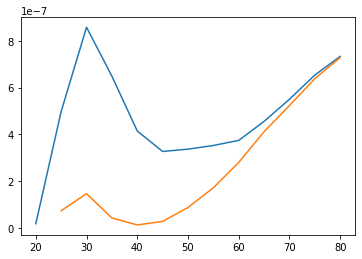

In [85]:
plt.plot(time,HCW_ups)
plt.plot(time,HCW_dns)

This is not going to work. Before I considered the whole shelf, but now I can't do that and it is hard to split what comes from each canyon.